In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Aug 18 15:48:34 2023

@author: coenberns
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as datetime
from datetime import datetime, timedelta, time
from Plot_EGG import*
from sklearn.metrics import mean_squared_error as mse
from scipy.interpolate import UnivariateSpline as univsp
from scipy.signal import savgol_filter
from scipy.signal import correlate
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
from sklearn.metrics import r2_score
#from functions_read_bursts import*

from compaction_read_burst import read_egg_v3_bursts, assign_groups, avg_time_diffs
# from Plot_EGG_adaptation import*

1. 08282023_5plushoursevening1.txt
2. 08282023_Ambulation.txt
3. 08282023_Ambulation_secondpart.txt
4. 08282023_aroundmidnight.txt
5. 08282023_beforemidnight-noon_day1-2.txt
6. 08282023_beginwithsleep.txt
7. 08282023_firstpartambu_noglitch.txt
8. 08282023_smallest_fortesting.txt
9. 08282023_smallpartbegin_at2pm.txt
File selected: 08282023_smallpartbegin_at2pm.txt
The total function took:  0.3488287925720215  to run
The total function took:  0.2915983200073242  to run
The total function took:  0.3389425277709961  to run
The total function took:  0.35999369621276855  to run
The total function took:  0.3683197498321533  to run
The total function took:  0.33329343795776367  to run


In [3]:
#folder_path = r"C:/Users/CoenBerns/OneDrive - Mass General Brigham/Documents/Thesis/Measurements/RF Readings miniPC/Battery testing/Slow_wave_input_1s840ms"
folder_path = r"C:/Users/CoenBerns/OneDrive - Mass General Brigham/Documents/Thesis/Measurements/RF readings miniPC desk animal facility/Signal Correlation/Sleep 1s840ms"
filepaths = []
statistics_meas = pd.DataFrame(columns=['Tx scheme',"Pearsonr", "MSE", "cosine", "R2", "mse_magnitude", "mse_phase"])

for filename in os.listdir(folder_path):
    filepath = os.path.join(folder_path, filename)
    if os.path.isfile(filepath):
        filepaths.append(filepath)

file = filepaths[0]

In [3]:
_, recorded_data, _ = read_egg_v3_bursts(file, mean=True, func=1, n_burst=1)

The total function took:  0.10677599906921387  to run


In [4]:
packets_batch=1
freq=50e-3

In [13]:
def extract_frequency_from_filename(file):
    """Extracts the frequency from the filename as float"""
    match = re.search(r'(\d+)(mHz)', file)
    if match:
        frequency_mHz = float(match.group(1))
        return frequency_mHz / 1000  # convert from mHz to Hz
    else:
        print("Could not find frequency in filename.")
        return None

def extract_packets_batch(file):
    """Extracts the amount of packets per R/S cycle sent from the filename as a str"""
    match = re.search(r'(\d+)(samps)', file)
    if match:
        n_samples = str(match.group(1))
        return n_samples
    else: 
        print("Could not find # of packets in batch in filename")
        return None

# Only necessary for Phase calculation 1, which is not used now
def calculate_initial_phase(recorded_waveform, amplitude):
    return np.arctan2(recorded_waveform[0], amplitude)

def sine_wave(t, amplitude, frequency, phase, offset):
    return amplitude * np.sin(2 * np.pi * frequency * t + phase) + offset

def generate_waveform(time_array, frequency, amplitude, offset, phase):
    """Generate a sinusoidal waveform for reference and initial phase+offset calculations"""
    waveform = amplitude * np.sin(2 * np.pi * frequency * time_array + phase) + offset
    return waveform

def cosine_similarity(x, y):
    """Calculate the cosine similarity between two signals x and y"""
    return np.dot(x - np.mean(x), y - np.mean(y)) / (np.sqrt(np.sum((x - np.mean(x)) ** 2)) * np.sqrt(np.sum((y - np.mean(y)) ** 2)))    

def calc_corr_stats(reference_signal, recorded_signal, fit_value = 101):
    """Calculation of statistic measures of the correlation between the two waveforms"""    
    #To account for the curve_fitted data in reference; for fairness
    reference_waveform_nonfit = reference_signal[fit_value:] 
    recorded_waveform_nonfit = recorded_signal[fit_value:]
    
    #Global synchrony variable pearson's r 
    pear_corr,_ = stats.pearsonr(reference_waveform_nonfit, recorded_waveform_nonfit)
    #Mean squared error between the signals
    mse = np.mean((reference_waveform_nonfit - recorded_waveform_nonfit) ** 2)
    #Cosine similarity
    cos_sim = cosine_similarity(reference_waveform_nonfit, recorded_waveform_nonfit)
    #coefficient of determination(r^2 score)
    r2 = r2_score(reference_waveform_nonfit, recorded_waveform_nonfit)
    
    #Additional magnitude and phase calculations in Fourier domain
    # Compute the FFT of each signal
    fft_recorded = np.fft.rfft(recorded_waveform_nonfit)
    fft_reference = np.fft.rfft(reference_waveform_nonfit)
    
    # Compute the magnitudes and phases
    magnitudes_recorded = np.abs(fft_recorded)
    phases_recorded = np.angle(fft_recorded)
    magnitudes_reference = np.abs(fft_reference)
    phases_reference = np.angle(fft_reference)
    
    # Compute mean square error for comparison ()
    mse_magni = np.mean((magnitudes_reference - magnitudes_recorded) ** 2)
    mse_phases = np.mean((phases_reference - phases_recorded) ** 2)
    
    statistics = {"Pearsonr": pear_corr, "MSE": mse, "cosine": cos_sim, "R2": r2, "mse_magnitude": mse_magni, "mse_phase": mse_phases}
            
    return statistics

def evaluate_recording(file, channel=0, frequency=50e-3, amplitude=2.5, offset=-37.5, sample_rate=62.5, n_burst=5):
    """Creation of the recording waveform and reference waveform, based on input and curve fitting parameters """
    
    # load and retrieve necessary data
    _, recorded_data, _ = read_egg_v3_bursts(file, n_burst=n_burst, mean=True, func=1, scale=300)
    recorded_data = recorded_data.dropna()
    recorded_waveform = recorded_data[f"Channel {channel}"].values[51:]
    #print(recorded_waveform)
        
    timestamps = recorded_data["corrected_t_f1"].values[51:]
    #There is one example where the phase correction weirdly is 90 off (n=3 sent samples)
    weird_phase = extract_packets_batch(file)
    
    # # Phase calculation 1
    # phase = calculate_initial_phase(recorded_waveform, amplitude)
    
    #Phase Calculation 2 
    # Fit the first 100 data points using non-linear least square error function curve_fit
    t = timestamps[:50]
    initial_guess = [amplitude, frequency, 0, offset]  #phase = 0
    
    #Boundary setting for if the recorded signal is very diffent due to parsing; for correlation, otherwise corr values still too high
    lower_bound = [1, 20e-3, -90, -40]
    upper_bound = [50, 500e-3, 90, -35]
    bounds = (lower_bound, upper_bound)
    
    popt, pcov = curve_fit(sine_wave, xdata=t, ydata=recorded_waveform[:50], p0=initial_guess, bounds=bounds, maxfev = 1000) #maxfev can be lower probably, may save calc time
    
    # Optimized parameters for [amplitude, frequency, phase, offset]
    _, _, phase_opt, offset_opt = popt
    
    #For this particular batch of measurements, something weird happens with the optimal phase of n=3
    if weird_phase == '3':
        print(weird_phase)
        phase_opt = 90
    else: 
        print("No weird phase observed")
    
    print(f'Optimized phase: {phase_opt}')
    print(f'Optimized offset: {offset_opt}')
    
    # generate the reference waveform, correcting for the offset and the phase recording starts at
    reference_waveform = generate_waveform(timestamps, frequency, amplitude, offset_opt, phase_opt)

    statistics =  calc_corr_stats(reference_waveform, recorded_waveform, fit_value=51)
    
    # return recording data, timestamps, correlation, statistics, and the waveforms (returning them for inspection now, later can be altered)
    return recorded_data, timestamps, recorded_waveform, reference_waveform, statistics 

def plot_signals_and_correlation(time, recorded_signal, n_batch, reference_signal, freq=62.5):
    """Plotting the two signals in order to visualize correlation, """
    plt.figure(figsize=(14, 14))

    # Plot the recorded and reference signals
    plt.subplot(2, 1, 1)
    plt.plot(time, recorded_signal, label='Recorded signal (transmitted: {})'.format(n_batch), marker='o', markersize=5)
    plt.plot(time, reference_signal, label='Reference signal')
    #plt.title("Recorded vs reference input ({:.0f} mHz)".format(freq*1000), size=20)
    plt.xlabel('Time [s]', size=16)
    plt.ylabel('Averaged potential [mV]', size=16)
    plt.legend(loc=9, fontsize=16)
    plt.ylim(-40.5,-33.5)
    #plt.xlim(100,300)
    plt.xticks(size=14)
    plt.yticks(size=14)
    #plt.xlim(150,175)

    # plt.tight_layout()
    plt.show()


The total function took:  0.11007833480834961  to run
Could not find frequency in filename.


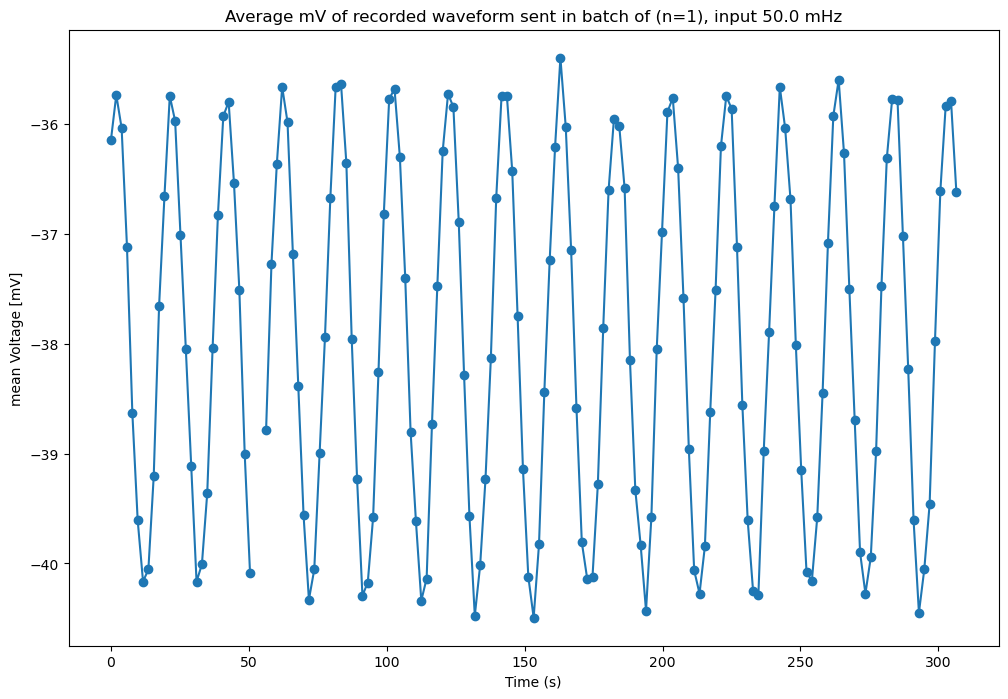

In [6]:
#For 1,2,3,4 in the burst plots... 
def plot_signal(file,channel=0, n_burst=5, freq=50e-3):
    """Plotting of the recorded signal only, adding frequency and batch number"""    
    #Preprocessing of the data
    _, recorded_data, _ = read_egg_v3_bursts(file, n_burst=n_burst, scale=300)
    time = recorded_data['corrected_t_f1']
    recorded_signal = recorded_data['Channel {}'.format(channel)]
    frequency = extract_frequency_from_filename(file)
    
    #Plotting
    plt.figure(figsize=(12, 8))
    
    plt.plot(time, recorded_signal, marker='o')
    plt.title(f"Average mV of recorded waveform sent in batch of (n={n_burst}), input {freq*1000} mHz")
    plt.xlabel('Time (s)')
    plt.ylabel('mean Voltage [mV]')    
    #plt.xlim(0:100)

plot_signal(filepaths[0], channel=0, n_burst=1)

In [14]:
recorded_data, timestamps, recorded_waveform, reference_waveform, statistics = evaluate_recording(file, n_burst=1)

The total function took:  0.08553886413574219  to run
Could not find # of packets in batch in filename
No weird phase observed
Optimized phase: 1.0607689569343077
Optimized offset: -38.00904923695341


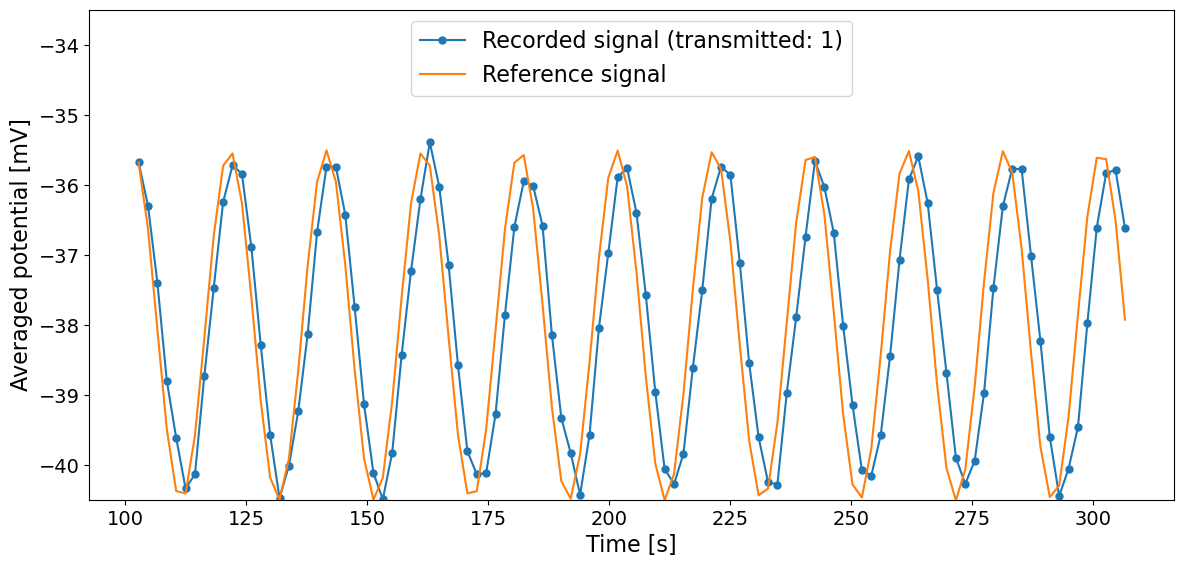

In [15]:
plot_signals_and_correlation(timestamps, recorded_waveform, packets_batch, reference_waveform, freq)

In [16]:
statistics_meas = pd.DataFrame(columns=['Tx scheme',"Pearsonr", "MSE", "cosine", "R2", "mse_magnitude", "mse_phase"])
statistics_meas = pd.concat([statistics_meas, pd.DataFrame(statistics, index=[0])], ignore_index=True)

C:\Users\CoenBerns\AppData\Local\Temp\ipykernel_25516\1070122476.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  statistics_meas = pd.concat([statistics_meas, pd.DataFrame(statistics, index=[0])], ignore_index=True)


In [17]:
statistics_meas

,Tx scheme,Pearsonr,MSE,cosine,R2,mse_magnitude,mse_phase
0,NaN,0.836395,0.967025,0.836395,0.689613,3.205221,1.256646
